# Task A2 - Smiling Detection
by MOHAMED AZMIL IRFAN MOHAMED AMIRUDDIN

(AMLS 19/20 ASSIGNMENT)

## Import Libraries

In [1]:
import os
import cv2
import dlib
import requests
import numpy as np
import pandas as pd
from pandas import DataFrame
from keras.preprocessing import image
from sklearn import svm
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt

%matplotlib inline
# required magic function

Using TensorFlow backend.
C:\Users\Bear-\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Bear-\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Bear-\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Bear-\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

## Change directory to one level up
relevant folder
1. Image directory : ..\AMLS_19-20_SN15053755\dataset\celeba\img
2. Label CSV file directory : ..\AMLS_19-20_SN15053755\dataset\celeba\labels.csv

In [2]:
os.chdir("..")
print(os.path.abspath(os.curdir))

C:\Users\Bear-\Desktop\AMLS_19-20_SN15053755


In [3]:
labels_filename = 'labels.csv'

basedir = os.path.abspath(os.curdir)
dataset_dir = os.path.join(basedir,'dataset')
celeba_dir = os.path.join(dataset_dir,'celeba')
images_dir = os.path.join(celeba_dir,'img')
labels_dir = os.path.join(celeba_dir,labels_filename)

In [4]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

## Testing Smiling Detection from HaarCascade 

### Downloading HaarCascade

In [5]:
# Downloading haarcascade feature set from github
def __downloadCascadeFF():
    print("Downloading haarcascade for face detection")
    url = "https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml"
    folder = "./A2/"
    local_filename = folder + url.split('/')[-1]
    # Check if already exists on users disk
    if not os.path.exists(folder):
        os.makedirs(folder)
    # Stream download dataset to local disk
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)


def __downloadCascadeS():
    print("Downloading haarcascade for smile detection")
    url = "https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_smile.xml"
    folder = "./A2/"
    local_filename = folder + url.split('/')[-1]
    # Check if already exists on users disk
    if not os.path.exists(folder):
        os.makedirs(folder)
    # Stream download dataset to local disk
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)                
                
__downloadCascadeFF()
__downloadCascadeS()

In [6]:
face_cascade = cv2.CascadeClassifier('C:\\Users\\Bear-\\Desktop\\AMLS_19-20_SN15053755\\A2\\haarcascade_frontalface_default.xml')
smile_cascade = cv2.CascadeClassifier('C:\\Users\\Bear-\\Desktop\\AMLS_19-20_SN15053755\\A2\\haarcascade_smile.xml')

### Testing HaarCascade Smile

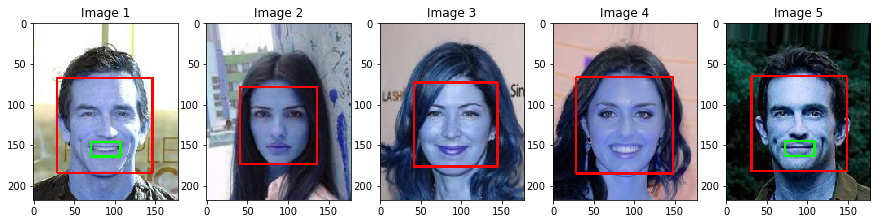

In [7]:
def detection(images_dir, image):
    img_path = os.path.join(images_dir, image)
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(img_gray, 1.3, 5)
    for (x,y,w,h) in faces:
        img = cv2.rectangle(img,(x,y),(x+w,y+h), (255,0,0), 2)
        roi_gray = img_gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        
        smiles = smile_cascade.detectMultiScale(roi_gray, 1.7, 20)
        for (sx,sy,sw,sh) in smiles:
            cv2.rectangle(roi_color,(sx,sy),(sx+sw,sy+sh), (0,255,0), 2)
            
    return img

example_image = ['37.jpg','25.jpg','82.jpg','42.jpg','81.jpg']
list_image = []
for img in example_image:
    list_image.append(detection(images_dir, img))
    
fig = plt.figure(figsize=(15,15))
num_images = len(list_image)

for image_idx in range(num_images):
    # Keep an incrementing count of each image
    a=fig.add_subplot(1, num_images, image_idx+1)
    # Add the image to the plot
    image_plot = plt.imshow(list_image[image_idx])
    # Add a caption with the folder name
    a.set_title("Image " + str(image_idx+1))

plt.show()

HaarCascade for smiling is questionable based on this 5 images. Image 1 is true positive while Image 2 is true negative. However, Image 3,4 are false negative while Image 5 is false positive. Regardless, this classifier will be evaluated later.

## Feature Extraction

In [8]:
def extract_features_labels(images_dir, labels_dir):
    """ return:
        landmark_features:  an array containing 68 landmark points for each image in celeba folder
        gender_labels:      an array containing the gender label (male=0 and female=1) for each image
    """
    image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)] ##filename in matrix
    target_size = None
    labels_file = open(labels_dir, 'r')
    lines = labels_file.readlines()
    gender_labels = {line.split('\t')[0] : int(line.split('\t')[3]) for line in lines[1:]} ##fetch filename + label smiling
    if os.path.isdir(images_dir):
        all_features = []
        red_features = []
        all_labels = []
        for img_path in image_paths:
            file_name= img_path.split('.')[0].split('\\')[-1] ##getting name of file; remove png/jpg + dir

            # load image
            img = image.img_to_array(
                image.load_img(img_path,
                               target_size=target_size,
                               interpolation='bicubic'))
            features, _ = run_dlib_shape(img)
            x= features
            if features is not None:
                all_features.append(features)
                red_features.append(np.concatenate((x[0:17],x[48:68])))
                all_labels.append(gender_labels[file_name])
                

    landmark_features = np.array(all_features)
    reduced_features = np.array(red_features)
    gender_labels = (np.array(all_labels) + 1)/2 # converts the -1 into 0, so male=0 and female=1
    return landmark_features, gender_labels, reduced_features

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)


def run_dlib_shape(image):
    # in this function we load the image, detect the landmarks of the face, and then return the image and the landmarks
    # load the input image, resize it, and convert it to grayscale
    resized_image = image.astype('uint8')

    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    gray = gray.astype('uint8')

    # detect faces in the grayscale image
    rects = detector(gray, 1)
    num_faces = len(rects)

    if num_faces == 0:
        return None, resized_image

    face_areas = np.zeros((1, num_faces))
    face_shapes = np.zeros((136, num_faces), dtype=np.int64)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        temp_shape = predictor(gray, rect)
        temp_shape = shape_to_np(temp_shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)],
        #   (x, y, w, h) = face_utils.rect_to_bb(rect)
        (x, y, w, h) = rect_to_bb(rect)
        face_shapes[:, i] = np.reshape(temp_shape, [136])
        face_areas[0, i] = w * h
    # find largest face and keep
    dlibout = np.reshape(np.transpose(face_shapes[:, np.argmax(face_areas)]), [68, 2])

    return dlibout, resized_image
    
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

In [9]:
print(os.path.abspath(os.curdir))

C:\Users\Bear-\Desktop\AMLS_19-20_SN15053755


## Processing Image using Feature Extraction

In [10]:
feature, label, shrink = extract_features_labels(images_dir, labels_dir)

print(len(feature))
print(len(shrink))
print(len(label))

4800
4800
4800


## Splitting Data into training and testing

In [11]:
def split_data_68(image_feature, image_label):
    i,j,k,l = train_test_split(image_feature, image_label, test_size = 0.2, random_state=42)
    train_image = i.reshape((len(i), 68*2))
    train_label = totuple(k)
    test_image = j.reshape((len(j), 68*2))
    test_label = totuple(l)
    
    return train_image, train_label, test_image, test_label

def split_data_37(image_feature, image_label):
    i,j,k,l = train_test_split(image_feature, image_label, test_size = 0.2, random_state=42)
    train_image = i.reshape((len(i), 37*2))
    train_label = totuple(k)
    test_image = j.reshape((len(j), 37*2))
    test_label = totuple(l)
    
    return train_image, train_label, test_image, test_label

train_image, train_label, test_image, test_label = split_data_68(feature, label)
redtr_img, redtr_lab, redte_img, redte_lab = split_data_37(shrink, label)

## Training Data

### 1. Using dummy classifier
Based on most frequent. To provide guidelines on the estimation accuracy

In [12]:
clf_dummy = DummyClassifier(strategy= 'most_frequent').fit(train_image, train_label)
pred1 = clf_dummy.predict(test_image)
print(accuracy_score(test_label, pred1))

0.5333333333333333


### 2. Using SVC with RBF kernel

In [ ]:
# defining parameter range 
param_grid_1 = {'C': [0.001, 0.01, 0.1, 10],  
              'gamma': [0.001, 0.01, 0.1, 1, 10], 
              'kernel': ['rbf']}

# run grid search
grid_1 = GridSearchCV(SVC(), param_grid_1, n_jobs = 4, refit = True, verbose = 3) 
grid_1 = grid_1.fit(train_image, train_label)

# set clf_rbf to best hyper-parameter
clf_rbf = grid_1.best_estimator_
clf_rbf.fit(train_image, train_label)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   35.2s


In [ ]:
print("Best hyper-parameter tuning :")
print(grid_1.best_params_)

In [ ]:
pred2 = clf_rbf.predict(test_image)
print(accuracy_score(test_label, pred2))

### 3. Using Linear Kernel

In [ ]:
# defining parameter range 
param_grid_2 = {'C': [0.01, 0.1, 10],  
              'gamma': [0.001, 0.01, 0.1, 1, 10], 
              'kernel': ['linear']}

# run grid search
grid_2 = GridSearchCV(SVC(), param_grid_2, n_jobs = 4, refit = True, verbose = 3) 
grid_2 = grid_2.fit(train_image, train_label)

# set clf_rbf to best hyper-parameter
clf_lin = grid_2.best_estimator_
clf_lin.fit(train_image, train_label)

In [ ]:
print("Best hyper-parameter tuning :")
print(grid_2.best_params_)

In [ ]:
pred3 = clf_lin.predict(test_image)
print(accuracy_score(test_label, pred3))

## Compare both classifier with reduced dimension of feature extraction

In [ ]:
redtr_img, redtr_lab, redte_img, redte_lab = split_data_37(shrink, label)

clf1 = SVC(C=0.1, gamma = 0.001, kernel='rbf')
clf1.fit(redtr_img, redtr_lab)
pred_red1 = clf1.predict(redte_img)
print(accuracy_score(redte_lab, pred_red1))

In [ ]:
clf2 = SVC(C=0.01 , gamma =0.001 , kernel='linear')
clf2.fit(redtr_img, redtr_lab)
pred_red2 = clf2.predict(redte_img)
print(accuracy_score(redte_lab, pred_red2))

In [ ]:
summary = {'Classifier' : ['SVC w/ RBF kernel','SVC w/ RBF kernel - Reduced Dimension','SVC w/ Linear Kernel','SVC w/ Linear kernel - Reduced Dimension'],
           'Accuracy Score' : [accuracy_score(test_label,pred2), accuracy_score(test_label, pred3), accuracy_score(redte_lab, pred_red1), accuracy_score(redte_lab, pred_red2)]}

summarydf = DataFrame(summary, columns= ['Classifier', 'Accuracy Score'])

print(summarydf)

As it can be seen, the classifier produces similar accuracy result by using reduced dimension (only Jaw and Mouth coordinates is taken). Hence, it is wise to use reduced dimension to save processing power and time

## Model Validation

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y,
                                                                          cv=cv, n_jobs=n_jobs,
                                                                          train_sizes=train_sizes,
                                                                          return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt, train_scores_mean, test_scores_mean


fig, axes = plt.subplots(3, 4, figsize=(10, 15))

X = feature.reshape((len(feature), 68*2))
newX = shrink.reshape((len(shrink), 37*2))
y = totuple(label)

newclf_rbf = SVC(C=10, gamma = 0.001, kernel='rbf')
newclf_lin = SVC(C=0.01 , gamma = 0.001, kernel = 'linear')

title = "Learning Curves (Kernel = rbf)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = newclf_rbf
plt1,_ ,_ = plot_learning_curve(estimator, title, X, y, axes=axes[:, 0],
                    cv=cv, n_jobs=4)

title = "Learning Curves (Kernel = rbf) with reduced dimension"
plt2,_ ,_ = plot_learning_curve(estimator, title, newX, y, axes=axes[:,1], cv=cv, n_jobs=4)


title = r"Learning Curves (Kernel = linear)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = newclf_lin
plt3,_ ,_ = plot_learning_curve(estimator, title, X, y, axes=axes[:, 2],
                    cv=cv, n_jobs=4)

title = r"Learning Curves (Kernel = linear) with reduced dimension"
plt4,k1,k2 = plot_learning_curve(estimator, title, newX, y, axes=axes[:,3], cv=cv, n_jobs=4)


plt.show()

In [ ]:
print(k1)
print(k2)

## Model Validation

Generating predictions from validation data..


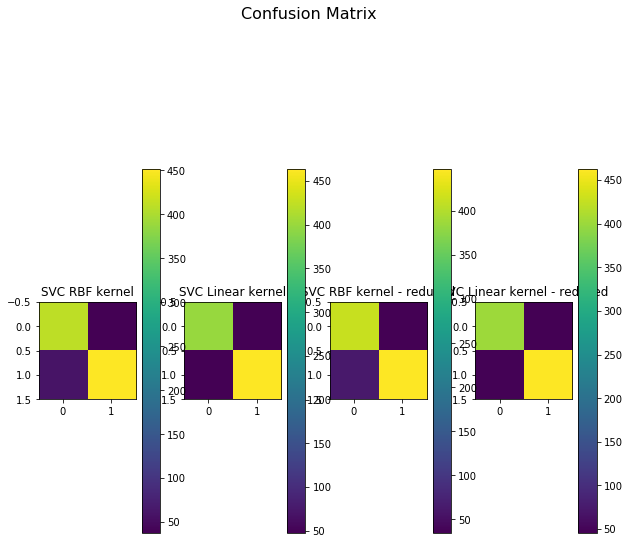

In [24]:
print("Generating predictions from validation data..")

cm1 = confusion_matrix(test_label, pred2)
cm2 = confusion_matrix(test_label, pred3)
cm3 = confusion_matrix(redte_lab, pred_red1)
cm4 = confusion_matrix(redte_lab, pred_red2)


fig, axs = plt.subplots(1, 4 ,figsize=(10, 10))

im1 = axs[0].imshow(cm1)
fig.colorbar(im1, ax=axs[0])
axs[0].set_title("SVC RBF kernel")

im2 = axs[1].imshow(cm2)
fig.colorbar(im2, ax=axs[1])
axs[1].set_title("SVC Linear kernel")

im3 = axs[2].imshow(cm3)
fig.colorbar(im3, ax=axs[2])
axs[2].set_title("SVC RBF kernel - reduced")

im4 = axs[3].imshow(cm4)
fig.colorbar(im4, ax=axs[3])
axs[3].set_title("SVC Linear kernel - reduced")

fig.suptitle('Confusion Matrix', fontsize=16)

plt.show()

In [25]:
evaluation = {'Classifier': ['SVC RBF','SVC Linear','SVC RBF - reduced','SVC Linear - reduced'],
              'Accuracy Score' : [accuracy_score(test_label,pred2),
                                  accuracy_score(test_label, pred3),
                                  accuracy_score(redte_lab, pred_red1),
                                  accuracy_score(redte_lab, pred_red2)],
              'Precision Score' : [precision_score(test_label, pred2),
                                   precision_score(test_label, pred3),
                                   precision_score(redte_lab, pred_red1),
                                   precision_score(redte_lab, pred_red2)],
              'Recall Score' : [recall_score(test_label, pred2),
                                recall_score(test_label, pred3),
                                recall_score(redte_lab, pred_red1),
                                recall_score(redte_lab, pred_red2)],
              'F1 Score': [f1_score(test_label, pred2),
                           f1_score(test_label, pred3),
                           f1_score(redte_lab, pred_red1),
                           f1_score(redte_lab, pred_red2)]}

evaldf = DataFrame(evaluation, columns = ['Classifier', 'Accuracy Score', 'Precision Score', 'Recall Score' , 'F1 Score'])

print(evaldf)

             Classifier  Accuracy Score  Precision Score  Recall Score  \
0               SVC RBF        0.897917         0.922449      0.882812   
1            SVC Linear        0.900000         0.906250      0.906250   
2     SVC RBF - reduced        0.896875         0.927536      0.875000   
3  SVC Linear - reduced        0.901042         0.909627      0.904297   

   F1 Score  
0  0.902196  
1  0.906250  
2  0.900503  
3  0.906954  


### Comparing detection using HaarCascade smile

In [26]:
def Diff(li1, li2): 
    return (list(set(li1) - set(li2)))

def detectionsmiling(images_dir, labels_dir):
    image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)]
    target_size = None
    labels_file = open(labels_dir,'r')
    lines = labels_file.readlines()
    smiling_label = {line.split('\t')[0] : int(line.split('\t')[2]) for line in lines[1:]}
    error_image = []
    all_image = []
    true_image = []
    pred_label = []
    real_label = []
    
    if os.path.isdir(images_dir):
        for img_path in image_paths:
            
            file_name = img_path.split('.')[0].split('\\')[-1]
            all_image.append(file_name)
            
            img = cv2.imread(img_path)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(img_gray, 1.3, 5)
            
            
            
            for(x,y,w,h) in faces:
#                 img = cv2.rectangle(img,(x,y),(x+w,y+h) (255,0,0), 2)
                roi_gray = img_gray[y:y+h, x:x+w]
#                 roi_color = img[y:y+h, x:x+w]

                true_image.append(file_name)
                smiling = 0
                smiles = smile_cascade.detectMultiScale(roi_gray, 1.7, 20)
                for (sx, sy, sw, sh) in smiles:
#                         cv2.rectangle(roi_color, (sx,sy), (sx+sw, sy+sh), (0,255,0), 2)
                    smiling = 1
                            
                pred_label.append(smiling)
                real_label.append(smiling_label[file_name])

        
    smile_label_real = (np.array(real_label)+1)/2
    smile_label_pred = np.array(pred_label)
    
    error_image = Diff(all_image,true_image)
    
    
    ## Remove some error ; inperfect function (Problem: Some images are printed twice.
    ## Number of true_image + error_image > total_image)
    templength = len(all_image) - len(error_image)
    for index in range(templength):
        if index+1 == templength:
            break
        if true_image[index] == true_image[index+1]:
            del true_image[index]
            smile_label_real = np.delete(smile_label_real, index)
            smile_label_pred = np.delete(smile_label_pred, index)
            index = index+1
            

    return smile_label_real, smile_label_pred, error_image
                    
real, pred, error = detectionsmiling(images_dir, labels_dir)

In [27]:
print(len(real))
print(len(pred))
print(len(error))

4434
4434
566


From the total 5000 images, only 4434 face is detected using face_HaarCascade. 

### accuracy, precision, recall and f1 score of HaarCascade
Appending to the previous dataframe for data visualisation

In [28]:
evaldf = evaldf.append({'Classifier' : 'Haar Cascade' , 'Accuracy Score' : accuracy_score(real,pred),
                        'Precision Score' : precision_score(real,pred), 'Recall Score' : recall_score(real,pred) ,
                        'F1 Score' : f1_score(real,pred)} , ignore_index=True)
print(evaldf)

             Classifier  Accuracy Score  Precision Score  Recall Score  \
0               SVC RBF        0.897917         0.922449      0.882812   
1            SVC Linear        0.900000         0.906250      0.906250   
2     SVC RBF - reduced        0.896875         0.927536      0.875000   
3  SVC Linear - reduced        0.901042         0.909627      0.904297   
4          Haar Cascade        0.520298         0.526205      0.116636   

   F1 Score  
0  0.902196  
1  0.906250  
2  0.900503  
3  0.906954  
4  0.190947  


HaarCascade Recall Score is 11%. The classifier has terribly high false negative. This is proven in the beginning where most smiles cant be detected.